# Synthetic Controls Methodology Test Notebook

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from geoflex.data import GeoPerformanceDataset
from geoflex.experiment_design import ExperimentDesign, GeoEligibility
from geoflex.metrics import Metric
from geoflex.methodology.synthetic_controls import SyntheticControls

/Users/omrigoldstein/geoflex/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuration

In [2]:
N_GEOS = 20
N_DAYS_PRE = 60
N_DAYS_POST = 30
TREATMENT_EFFECT = 1.1  # 10% lift
TREATMENT_START_DATE = pd.to_datetime('2025-03-01')
N_TREATMENT_GEOS = 5

## 3. Data Generation

In [3]:
def generate_correlated_pre_experiment_data(
        n_geos: int,
        n_days_pre: int,
        treatment_start_date: int
        ) -> pd.DataFrame:
    """Generates correlated pre-experiment data for multiple geos."""
    geos = [f'G{i+1}' for i in range(n_geos)]
    dates = pd.to_datetime(
        [treatment_start_date - dt.timedelta(days=x) for x in range(1, n_days_pre + 1)]
        )
    
    # Create a common trend
    common_trend = np.random.normal(loc=1000, scale=50, size=n_days_pre)
    
    data_frames = []
    for geo in geos:
        # Add geo-specific noise to the common trend
        geo_sales = common_trend + np.random.normal(loc=0, scale=20, size=n_days_pre)
        df = pd.DataFrame({'date': dates, 'geo_id': geo, 'sales': geo_sales})
        data_frames.append(df)
        
    return pd.concat(data_frames).sort_values(['geo_id', 'date']).reset_index(drop=True)

pre_experiment_df = generate_correlated_pre_experiment_data(
    N_GEOS, N_DAYS_PRE, TREATMENT_START_DATE
    )

print(f"Generated {len(pre_experiment_df)} rows of pre-experiment data.")
pre_experiment_df.head()

Generated 1200 rows of pre-experiment data.


,date,geo_id,sales
0,2024-12-31,G1,966.355640
1,2025-01-01,G1,1045.914031
2,2025-01-02,G1,1031.667323
3,2025-01-03,G1,969.959814
4,2025-01-04,G1,1041.405684


In [4]:
pre_experiment_df.geo_id.unique()

array(['G1', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16', 'G17',
       'G18', 'G19', 'G2', 'G20', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8',
       'G9'], dtype=object)

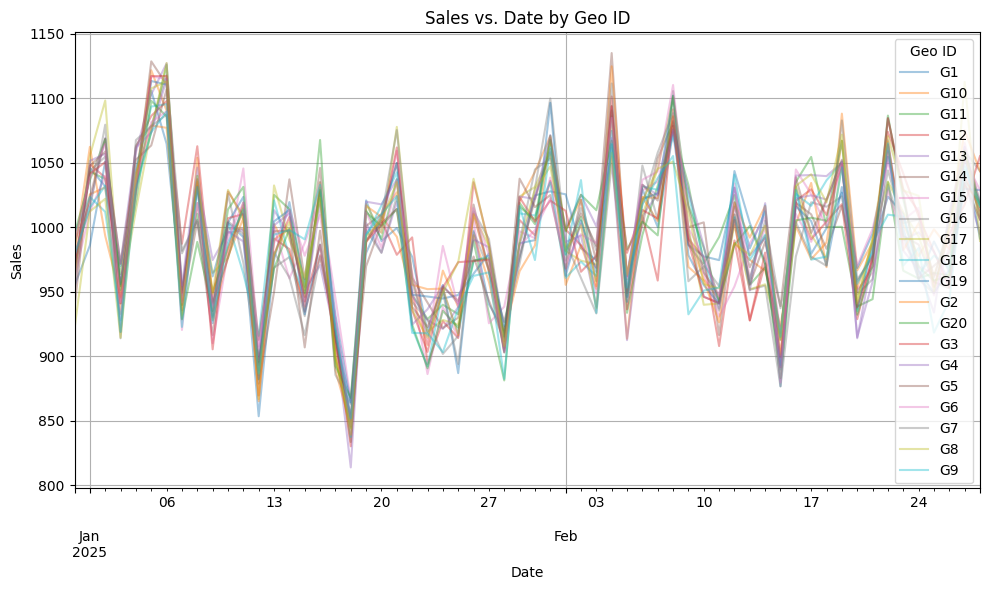

In [5]:
ax = pre_experiment_df.pivot(index='date', columns='geo_id', values='sales').plot(
    figsize=(10, 6),
    title='Sales vs. Date by Geo ID',
    alpha=0.4
)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.grid(True)
ax.legend(title='Geo ID')
plt.tight_layout()

## 4. Methodology Setup

In [6]:
geo_data = GeoPerformanceDataset(
    data=pre_experiment_df, geo_id_column='geo_id', date_column='date'
    )

geo_eligibility = GeoEligibility(
    exclude={'G1', 'G2', 'G8', 'G9'},
    treatment=[{'G3', 'G4', 'G5', 'G6', 'G7'}]
)

experiment_design = ExperimentDesign(
    primary_metric=Metric(name='sales'),
    methodology='SyntheticControls',
    runtime_weeks=4,
    methodology_parameters={"min_treatment_geos": 2, "num_iterations": 100},
    geo_eligibility=geo_eligibility

)

sc_method = SyntheticControls()

## 5. Geo Assignment

In [10]:
pretest_geo_data = GeoPerformanceDataset(
    data=pre_experiment_df, geo_id_column='geo_id', date_column='date'
    )

geo_assignment, _ = sc_method._methodology_assign_geos(
    experiment_design=experiment_design,
    historical_data=pretest_geo_data
)
experiment_design.geo_assignment = geo_assignment

print(f"Assigned Treatment Geos: {geo_assignment.treatment}")
print(f"Assigned Control Geos: {geo_assignment.control}")

Assigned Treatment Geos: [{'G3', 'G16', 'G13', 'G6', 'G7', 'G20', 'G10', 'G5', 'G4'}]
Assigned Control Geos: {'G15', 'G12', 'G18', 'G14', 'G19', 'G11', 'G17'}


## 6. Generate Post-Experiment Data and Combine

In [11]:
def generate_post_experiment_data(
        n_geos: int,
        n_days_post: int,
        treatment_start_date: str,
        treatment_effects: dict[int, float],
        geo_assignment: dict
        ) -> pd.DataFrame:
    """Generates post-experiment data and applies a lift to the treatment group."""
    geos = [f'G{i+1}' for i in range(n_geos)]
    dates = pd.to_datetime(
        [treatment_start_date + dt.timedelta(days=x) for x in range(n_days_post)]
        )
    
    common_trend = np.random.normal(loc=1000, scale=50, size=n_days_post)
    
    data_frames = []
    for geo in geos:
        geo_sales = common_trend + np.random.normal(loc=0, scale=20, size=n_days_post)
        df = pd.DataFrame({'date': dates, 'geo_id': geo, 'sales': geo_sales})
        data_frames.append(df)
        
    post_df = pd.concat(data_frames).sort_values(['geo_id', 'date']).reset_index(drop=True)
    
    # Apply treatment effect
    for i, treatment_cell in enumerate(geo_assignment.treatment):
        is_treatment_geo = post_df['geo_id'].isin(treatment_cell)
        post_df.loc[is_treatment_geo, 'sales'] *= treatment_effects[i]
    
    return post_df

assigned_treatment_geos = list(geo_assignment.treatment[0])
post_experiment_df = generate_post_experiment_data(
    N_GEOS, N_DAYS_POST, TREATMENT_START_DATE, {0: TREATMENT_EFFECT}, geo_assignment
    )

runtime_df = pd.concat([pre_experiment_df, post_experiment_df])
runtime_geo_data = GeoPerformanceDataset(
    data=runtime_df, geo_id_column='geo_id', date_column='date'
    )

print(f"Combined runtime data has {len(runtime_df)} rows.")
post_experiment_df.head()

Combined runtime data has 1800 rows.


,date,geo_id,sales
0,2025-03-01,G1,1009.216918
1,2025-03-02,G1,948.149683
2,2025-03-03,G1,963.454304
3,2025-03-04,G1,1003.761829
4,2025-03-05,G1,992.321247


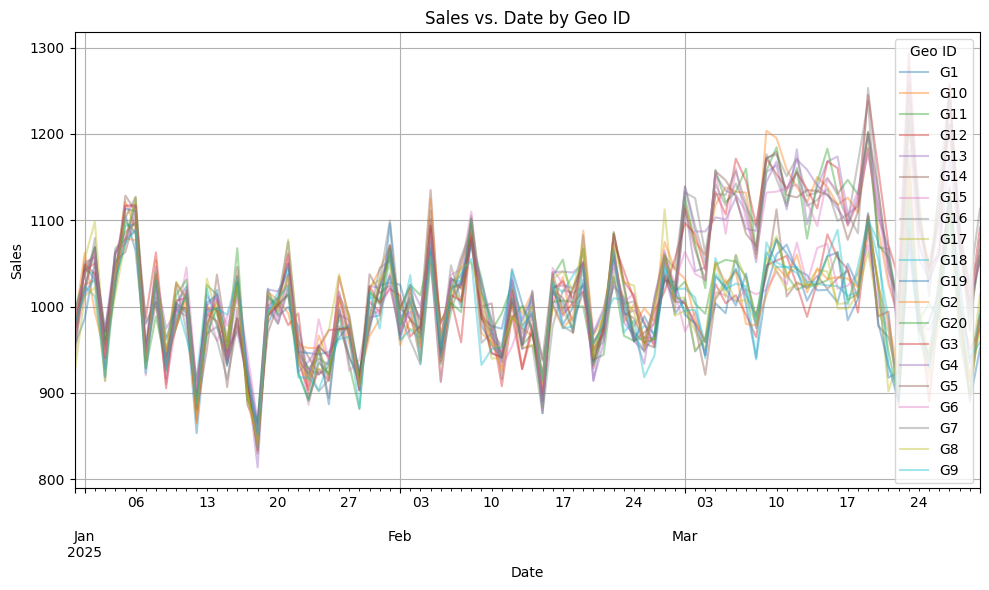

In [12]:
ax = runtime_df.pivot(index='date', columns='geo_id', values='sales').plot(
    figsize=(10, 6),
    title='Sales vs. Date by Geo ID',
    alpha=0.4
)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.grid(True)
ax.legend(title='Geo ID')
plt.tight_layout()

## 7. Experiment Analysis

In [13]:
pretest_end_date = TREATMENT_START_DATE - dt.timedelta(days=1)
experiment_end_date = TREATMENT_START_DATE + dt.timedelta(days=N_DAYS_POST - 1)

results_df, _ = sc_method._methodology_analyze_experiment(
    runtime_data=runtime_geo_data,
    experiment_design=experiment_design,
    experiment_start_date=TREATMENT_START_DATE,
    experiment_end_date=experiment_end_date,
    pretest_period_end_date=pretest_end_date,
)

## 8. Results

In [14]:
print("Analysis Results:")
results_df

Analysis Results:


,point_estimate,lower_bound,upper_bound,point_estimate_relative,lower_bound_relative,upper_bound_relative,p_value,metric,cell
0,101.439299,98.200798,104.6778,0.100192,0.080662,0.120422,1.791180e-30,sales,1


## 9. Multi-cell Experiment

Now, let's demonstrate a multi-cell (A/B/C) experiment. We will set `n_cells=3` in the `ExperimentDesign` to partition the geos into one control group and two treatment cells.

In [15]:
multicell_experiment_design = ExperimentDesign(
    primary_metric=Metric(name='sales'),
    methodology='SyntheticControls',
    runtime_weeks=4,
    n_cells=3,  # A/B/C test
    methodology_parameters={"min_treatment_geos": 2, "num_iterations": 100}
)

multicell_geo_assignment, _ = sc_method._methodology_assign_geos(
    experiment_design=multicell_experiment_design,
    historical_data=pretest_geo_data
)
multicell_experiment_design.geo_assignment = multicell_geo_assignment

print("Multi-cell Geo Assignment:")
print(f"Control Geos: {multicell_geo_assignment.control}")
for i, treatment_cell in enumerate(multicell_geo_assignment.treatment):
    print(f"Treatment Cell {i+1}: {treatment_cell}")

Multi-cell Geo Assignment:
Control Geos: {'G3', 'G16', 'G18', 'G13', 'G14', 'G19', 'G2', 'G10', 'G11'}
Treatment Cell 1: {'G9', 'G1', 'G6', 'G7', 'G4'}
Treatment Cell 2: {'G15', 'G12', 'G8', 'G20', 'G17', 'G5'}


## 10. Multi-cell Analysis

In [16]:
multicell_post_experiment_df = generate_post_experiment_data(
    N_GEOS, N_DAYS_POST, TREATMENT_START_DATE, {0: 1.1, 1: 1.2}, multicell_geo_assignment
    )

multicell_runtime_df = pd.concat([pre_experiment_df, multicell_post_experiment_df])
multicell_runtime_geo_data = GeoPerformanceDataset(
    data=multicell_runtime_df, geo_id_column='geo_id', date_column='date'
    )

multicell_results_df, _ = sc_method._methodology_analyze_experiment(
    runtime_data=multicell_runtime_geo_data,
    experiment_design=multicell_experiment_design,
    experiment_start_date=TREATMENT_START_DATE,
    experiment_end_date=experiment_end_date,
    pretest_period_end_date=pretest_end_date,
)

print("Multi-cell Analysis Results:")
multicell_results_df

Multi-cell Analysis Results:


,point_estimate,lower_bound,upper_bound,point_estimate_relative,lower_bound_relative,upper_bound_relative,p_value,metric,cell
0,97.834249,93.29413,102.374369,0.099427,0.080265,0.119241,7.861553e-26,sales,1
1,196.144104,192.09051,200.197699,0.199337,0.178893,0.220474,6.483594e-36,sales,2
